In [38]:
import statsmodels.api as sm
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import h3

# analysis

In [39]:
h3_l7_df = pd.read_csv('h3_l7_df_new.csv')

# 將 h3_l7_df 資料框中的 'id' 列移除，僅保留數據進行正規化
normalized_h3_l7_df = h3_l7_df.drop('id', axis=1)

# 對數據進行正規化：將每個數據列的最小值調整為 0，最大值調整為 1
normalized_h3_l7_df = (normalized_h3_l7_df - normalized_h3_l7_df.min()) / (normalized_h3_l7_df.max() - normalized_h3_l7_df.min())


X =  normalized_h3_l7_df.iloc[:,:-1]    # data without ID and OHCA
y =  normalized_h3_l7_df.iloc[:, -1]           # 標籤
# 增加常數項以包含截距
X = sm.add_constant(X)

In [40]:
# 建立線性回歸模型
mod = sm.OLS(y, X, missing='drop')
results = mod.fit()

#X內部相關性分析
correlation = X.corr()

# 輸出結果
print(correlation)

                  const  place_of_worship  grave_yard    school  post_office  \
const               NaN               NaN         NaN       NaN          NaN   
place_of_worship    NaN          1.000000    0.225917  0.550652     0.329350   
grave_yard          NaN          0.225917    1.000000  0.167167     0.002817   
school              NaN          0.550652    0.167167  1.000000     0.209546   
post_office         NaN          0.329350    0.002817  0.209546     1.000000   
...                 ...               ...         ...       ...          ...   
barn                NaN         -0.069444   -0.024726 -0.053801    -0.024726   
riding_hall         NaN         -0.051643   -0.018388 -0.040010    -0.018388   
construction        NaN          0.078920   -0.032031 -0.010387     0.113340   
ship                NaN          0.031455   -0.018388 -0.040010    -0.018388   
ruins               NaN         -0.051643   -0.018388 -0.040010    -0.018388   

                  childcare  university

In [41]:
# 輸出結果
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                   ohca   R-squared:                       0.990
Model:                            OLS   Adj. R-squared:                  0.977
Method:                 Least Squares   F-statistic:                     79.49
Date:                Fri, 29 Nov 2024   Prob (F-statistic):           9.97e-55
Time:                        11:09:13   Log-Likelihood:                 425.36
No. Observations:                 177   AIC:                            -654.7
Df Residuals:                      79   BIC:                            -343.5
Df Model:                          97                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     -0

# regression

In [42]:
train_index=[]
test_index=[]
for i in range(0,h3_l7_df.shape[0]):
    geo_location = h3.h3_to_geo(h3_l7_df.iloc[i]['id'])

    if (geo_location[1]) > (-76.05): #把經度大於-76.05的 當train (東邊是train)
        train_index.append(i)
    else:
        test_index.append(i)

print(len(train_index))
print(len(test_index))

83
94


In [43]:

# 將 h3_l7_df 資料框中的 'id' 列移除，僅保留數據進行正規化
h3_spatial_data = h3_l7_df.drop('id', axis=1)


# # # 對數據進行正規化：將每個數據列的最小值調整為 0，最大值調整為 1
normalized_spatial_data = (h3_spatial_data - h3_spatial_data.min()) / (h3_spatial_data.max() - h3_spatial_data.min())

#設定OHCA正規化反函數 方便把預測結果返回原本scale
ohca_reguli_inverse = (h3_l7_df.ohca.max()-h3_l7_df.ohca.min()) + h3_l7_df.ohca.min()

# 將 DataFrame 轉換為 numpy array，並設定數據類型為 np.float64
spatial_data = np.array(normalized_spatial_data).astype(np.float64)


train_spatial_data = spatial_data[train_index]
test_spatial_data = spatial_data[test_index]

# 分離特徵和標籤
X_train = train_spatial_data[:, :-1]   # features
y_train = train_spatial_data[:, -1]    # target
X_test = test_spatial_data[:, :-1]
y_test = test_spatial_data[:, -1]

# 增加常數項以包含截距
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

# 建立線性回歸模型
mod = sm.OLS(y_train, X_train, missing='drop')
res = mod.fit()

# 輸出結果
print("訓練結果：")
print(res.summary())

訓練結果：
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.996
Model:                            OLS   Adj. R-squared:                  0.989
Method:                 Least Squares   F-statistic:                     132.4
Date:                Fri, 29 Nov 2024   Prob (F-statistic):           2.23e-23
Time:                        11:09:13   Log-Likelihood:                 266.93
No. Observations:                  83   AIC:                            -421.9
Df Residuals:                      27   BIC:                            -286.4
Df Model:                          55                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0029      0.004      0.677   

In [44]:
# 使用模型進行預測
y_pred_train = res.predict(X_train)
#返回正規化前的值
y_pred_train = y_pred_train*(h3_l7_df.ohca.max()- h3_l7_df.ohca.min()) + h3_l7_df.ohca.min()
y_train = y_train*(h3_l7_df.ohca.max()- h3_l7_df.ohca.min()) + h3_l7_df.ohca.min()

# 計算測試集上的均方誤差
mae = np.abs(y_pred_train-y_train)
mae = mae.sum()/mae.shape[0]

print('MAE of test set= ',mae)

# 計算殘差變異
ss_residual = np.sum((y_train - y_pred_train) ** 2)

# 計算總變異量
ss_total = np.sum((y_train - np.mean(y_train)) ** 2)

# 計算 R²
r_squared = 1 - (ss_residual / ss_total)

print("R² of test set= ", r_squared)

MAE of test set=  0.4198256229473771
R² of test set=  0.9963068651953398


Text(0, 0.5, 'Reality')

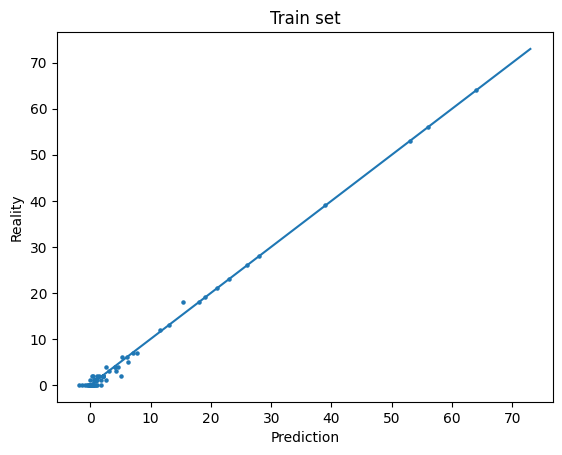

In [45]:
plt.scatter(y_pred_train,
            y_train,
            s = 5)
plt.plot([0, 73], [0, 73])
plt.title('Train set')
plt.xlabel('Prediction')
plt.ylabel('Reality')

In [46]:
# 使用模型進行預測
y_pred_test = res.predict(X_test)
#返回正規化前的值
y_pred_test = y_pred_test*(h3_l7_df.ohca.max()- h3_l7_df.ohca.min()) + h3_l7_df.ohca.min()
y_test = y_test*(h3_l7_df.ohca.max()- h3_l7_df.ohca.min()) + h3_l7_df.ohca.min()

# 計算測試集上的均方誤差
mae = np.abs(y_pred_test-y_test)
mae = mae.sum()/mae.shape[0]

print('MAE of test set= ',mae)

# 計算殘差變異
ss_residual = np.sum((y_test - y_pred_test) ** 2)

# 計算總變異量
ss_total = np.sum((y_test - np.mean(y_test)) ** 2)

# 計算 R²
r_squared = 1 - (ss_residual / ss_total)

print("R² of test set= ", r_squared)

MAE of test set=  9.396208920785039
R² of test set=  0.16931713324848563


Text(0, 0.5, 'Reality')

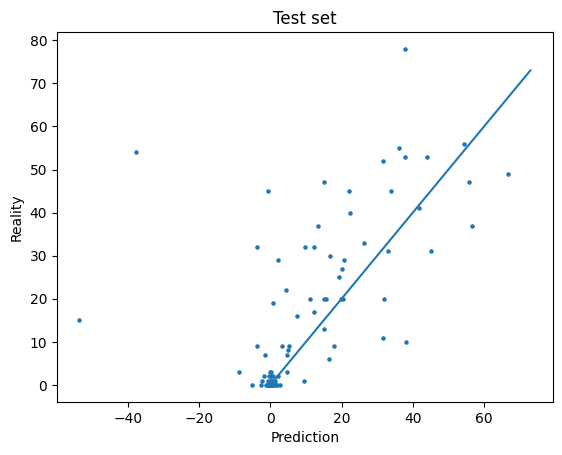

In [47]:
plt.scatter(y_pred_test,
            y_test,
            s = 5)
plt.plot([0, 73], [0, 73])
plt.title('Test set')
plt.xlabel('Prediction')
plt.ylabel('Reality')